# Gaussian processes

In [1]:
import torch
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

I start by creating some data to play with. To make the problem interesting, I'll use data with an upward trend and a periodic behavior.

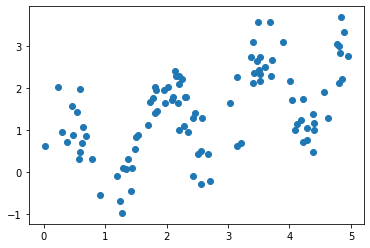

In [2]:
pyro.set_rng_seed(152)
# create test toy data
N_DATA = 100
noise = dist.Normal(0, 0.5).sample([N_DATA])
x = dist.Uniform(0.0, 5.0).sample([N_DATA])
y = torch.sin(4*x) + 0.5 * x + noise

# plot data
plt.scatter(x, y)
plt.show()

We can fit the data using a Gaussian process with an RBF kernel and log-normal priors on the variance and length parameters:

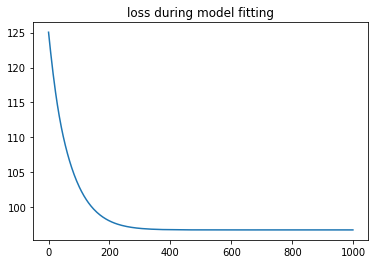

In [3]:
pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
gpr = gp.models.GPRegression(x, y, kernel, noise=torch.tensor(0.1))
# define priors for the variance and lengthscale hyperparams
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0., 1.))
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0., 1.))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
n_steps = 1000
for i in range(n_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.title('loss during model fitting')
plt.show()

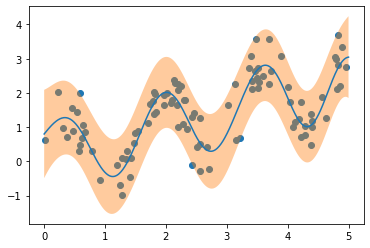

In [4]:
N_TEST = 500
plt.scatter(x, y)
x_pred = torch.linspace(0, 5, N_TEST)
with torch.no_grad():
    mean, covariance = gpr(x_pred, full_cov=True, noiseless=False)
sd = covariance.diag().sqrt()
plt.plot(x_pred.numpy(), mean.numpy())
plt.fill_between(x_pred.numpy(), (mean - 2 * sd).numpy(), (mean + 2 * sd).numpy(), alpha=0.4)
plt.show()

The fit is quite good, but what happens if we fit only on the data before x=4? How good is the model at forecasting future values?

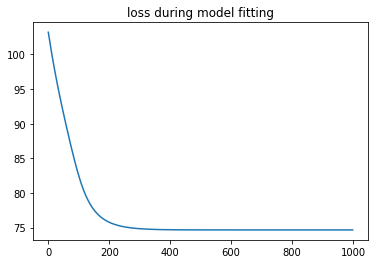

In [5]:
x_train, y_train = x[x < 4], y[x < 4]
x_test, y_test = x[x >= 4], y[x >= 4]

pyro.clear_param_store()
kernel = gp.kernels.RBF(input_dim=1)
gpr = gp.models.GPRegression(x_train, y_train, kernel, noise=torch.tensor(0.1))
# define priors for the variance and lengthscale hyperparams
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0., 1.))
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0., 1.))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
n_steps = 1000
for i in range(n_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.title('loss during model fitting')
plt.show()

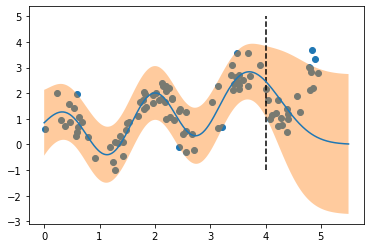

In [6]:
plt.scatter(x, y)
x_pred = torch.linspace(0, 5.5, 550)
with torch.no_grad():
    mean, covariance = gpr(x_pred, full_cov=True, noiseless=False)
sd = covariance.diag().sqrt()
plt.plot(x_pred.numpy(), mean.numpy())
plt.vlines(4, -1, 5, linestyles='dashed')
plt.fill_between(x_pred.numpy(), (mean - 2 * sd).numpy(), (mean + 2 * sd).numpy(), alpha=0.4)
plt.show()

Because the kernel is stationary, the future predicted values will regress to 0, which is clearly not how the data actually behave. We can fix this by using a non-stationary kernel:

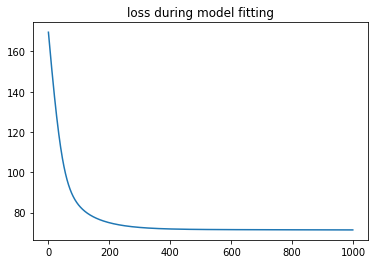

In [7]:
# define kernel as sum of RBF and linear kernel with constant
nonStationaryKernel = gp.kernels.Sum(gp.kernels.RBF(input_dim=1),
                                     gp.kernels.Polynomial(input_dim=1, degree=1))
pyro.clear_param_store()
gpr = gp.models.GPRegression(x_train, y_train, nonStationaryKernel, noise=torch.tensor(0.1))
# define priors for the variance and lengthscale hyperparams
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0., 1.))
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0., 1.))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.005)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
n_steps = 1000
for i in range(n_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.title('loss during model fitting')
plt.show()

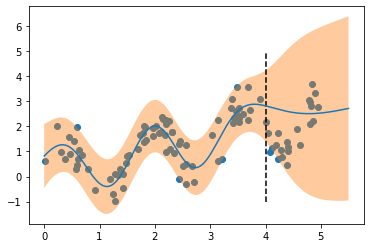

In [8]:
plt.scatter(x, y)
with torch.no_grad():
    mean, covariance = gpr(x_pred, full_cov=True, noiseless=False)
sd = covariance.diag().sqrt()
plt.plot(x_pred.numpy(), mean.numpy())
plt.vlines(4, -1, 5, linestyles='dashed')
plt.fill_between(x_pred.numpy(), (mean - 2 * sd).numpy(), (mean + 2 * sd).numpy(), alpha=0.4)
plt.show()

Now the predictions are much more reasonable, although the variance is very high, to the point of being nearly useless, once we enter the predictive region. We can also see that the model is not really making use of the periodicity of the data. We can improve predictions by using a periodic kernel to make use of the periodic nature of the data:

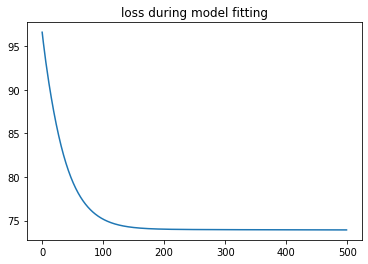

In [9]:
# keep the nonstationary (linear) behavior but add periodic behavior
periodicKernel = gp.kernels.Sum(gp.kernels.Periodic(input_dim=1),
                                gp.kernels.Polynomial(input_dim=1, degree=1))
pyro.clear_param_store()
gpr = gp.models.GPRegression(x_train, y_train, periodicKernel, noise=torch.tensor(0.1))
# define priors for the hyperparams
gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0., 1.))
gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0., 1.))
gpr.kernel.kern0.period = pyro.nn.PyroSample(dist.LogNormal(1., 1.))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
n_steps = 500
for i in range(n_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.title('loss during model fitting')
plt.show()

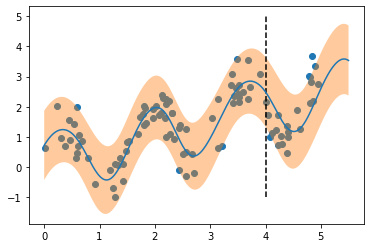

In [10]:
plt.scatter(x, y)
x_pred = torch.linspace(0, 5.5, 550)
with torch.no_grad():
    mean, covariance = gpr(x_pred, full_cov=True, noiseless=False)
sd = covariance.diag().sqrt()
plt.plot(x_pred.numpy(), mean.numpy())
plt.vlines(4, -1, 5, linestyles='dashed')
plt.fill_between(x_pred.numpy(), (mean - 2 * sd).numpy(), (mean + 2 * sd).numpy(), alpha=0.4)
plt.show()

We now have very accurate predictions that effectively make use of the data.

Let's see how this works with a real time series (U.S. log GDP):

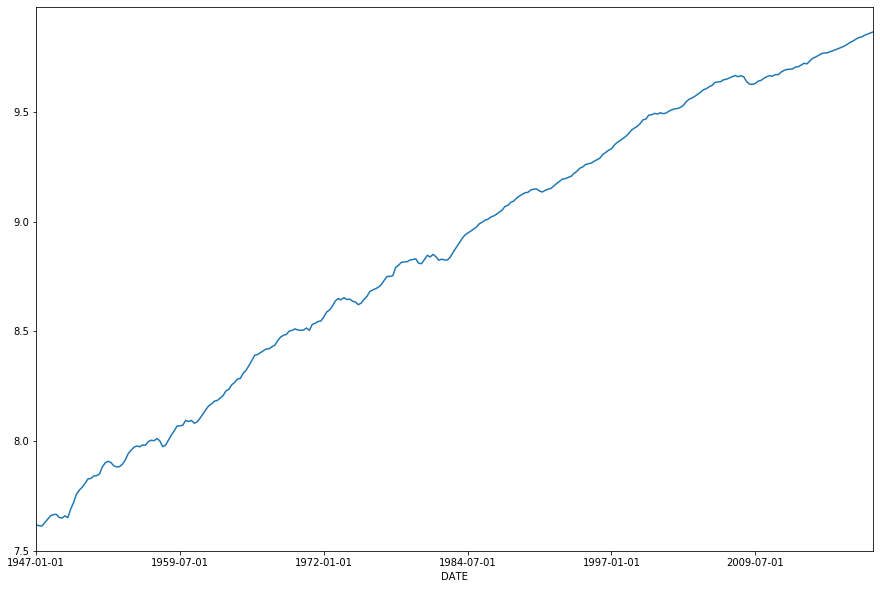

In [11]:
df = pd.read_csv('time_series/GDPC1.csv', index_col=0)
df['logGDP'] = df['GDPC1'].apply(np.log)
df['logGDP'].plot(figsize=(15,10))
plt.show()

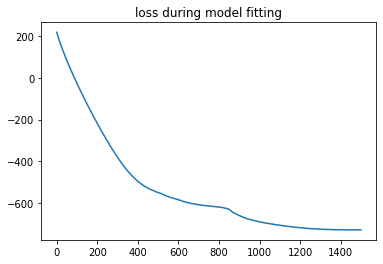

In [12]:
t = torch.arange(len(df)).double()
polyKernel = gp.kernels.Sum(gp.kernels.RBF(1), gp.kernels.Polynomial(1, degree=2))

pyro.clear_param_store()
gpr = gp.models.GPRegression(t[:4*len(df)//5], torch.from_numpy(df['logGDP'].values[:4*len(df)//5]).double(),
                             polyKernel, noise=torch.tensor(0.1))
# define priors for the hyperparams
# gpr.kernel.kern0.variance = pyro.nn.PyroSample(dist.LogNormal(0., 1.))
# gpr.kernel.kern0.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0., 1.))

optimizer = torch.optim.Adam(gpr.parameters(), lr=0.01)
loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
losses = []
n_steps = 1500
for i in range(n_steps):
    optimizer.zero_grad()
    loss = loss_fn(gpr.model, gpr.guide)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
plt.plot(losses)
plt.title('loss during model fitting')
plt.show()

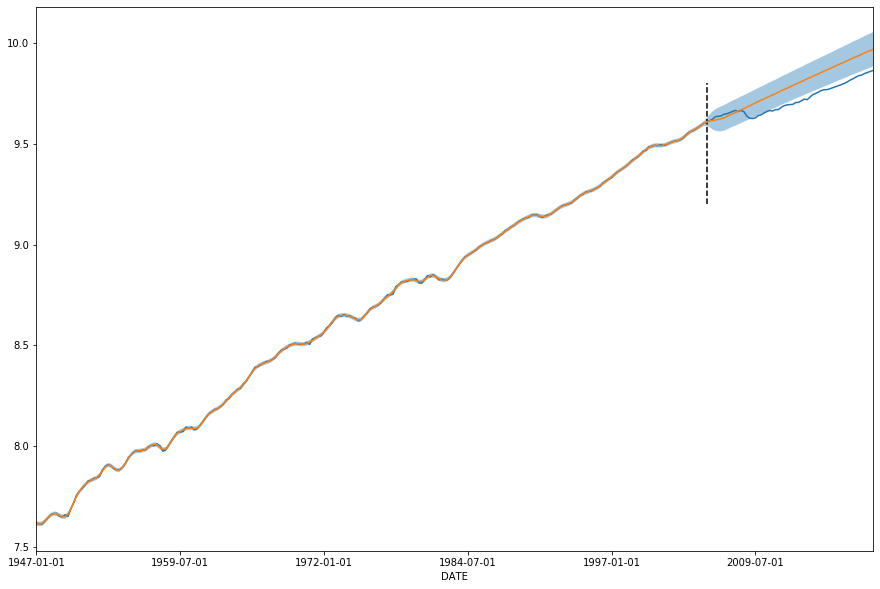

In [13]:
df['logGDP'].plot(figsize=(15,10))
with torch.no_grad():
    mean, covariance = gpr(t, full_cov=True, noiseless=False)
sd = covariance.diag().sqrt()
plt.plot(t.numpy(), mean.numpy())
plt.vlines(4*len(df)//5, 9.2, 9.8, linestyles='dashed')
plt.fill_between(t.numpy(), (mean - 2 * sd).numpy(), (mean + 2 * sd).numpy(), alpha=0.4)
plt.show()